In [1]:
import torch
from torch_geometric.loader import DataLoader
from torchmetrics import MeanSquaredError, R2Score, SpearmanCorrCoef, PearsonCorrCoef
from torchmetrics import Accuracy, Precision, Recall, F1Score

from tqdm import tqdm
import wandb
import argparse
from datetime import datetime
import os

from dataset0403 import MegaThermoProtT5Template as Dataset
from model0408 import GCNfly3_pair_distogram_dual as Model

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [25]:
device = torch.device('cuda:5' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

val_loader, test_loader, debug_loader = False, False, False
!nvidia-smi

Using device: cuda:5
Fri Apr 12 16:07:28 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:1B:00.0 Off |                    0 |
| 42%   67C    P2   116W / 230W |   3232MiB / 23028MiB |     31%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    Off  | 00000000:1C:00.0 Off |           

In [12]:
split='test' # 2min~
criterion = torch.nn.KLDivLoss(reduction="batchmean")

if split == 'val':
    if not val_loader:
        val_dataset = Dataset(split=split)
        val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=False, num_workers=8, pin_memory=True)
    loader = val_loader
        
elif split == 'test':
    if not test_loader:
        test_dataset = Dataset(split=split)
        test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False, num_workers=8, pin_memory=True)
    loader = test_loader
    
elif split == 'debug':
    if not debug_loader:
        debug_dataset = Dataset(split=split)
        debug_loader = DataLoader(debug_dataset, batch_size=1024, shuffle=False, num_workers=8, pin_memory=True)
    loader = debug_loader

In [5]:
def distogram(D):
    # D_min, D_max, D_count = -1., 5., 13
    D_min, D_max, D_count = 0., 1., 25
    D_mu = torch.linspace(D_min, D_max, D_count, device=D.device)
    D_sigma = (D_max - D_min) / D_count
    D_expand = torch.unsqueeze(D, -1)
    softmax = torch.nn.Softmax(dim=-1)
    RBF = torch.exp(-((D_expand - D_mu) / D_sigma) ** 2)
    # return softmax(RBF)
    return softmax(2*RBF)


def get_metrics() -> dict:
    return {
        "r2": R2Score(),
        "mse": MeanSquaredError(squared=True),
        "rmse": MeanSquaredError(squared=False),
        "spearman": SpearmanCorrCoef(),
        "pearson": PearsonCorrCoef(),
    }

class JSD(torch.nn.Module):
    def __init__(self):
        super(JSD, self).__init__()
        self.kl = torch.nn.KLDivLoss(reduction='batchmean', log_target=True)
        
    def forward(self, p: torch.tensor, q: torch.tensor):
        p, q = p.view(-1, p.size(-1)), q.view(-1, q.size(-1))
        m = (0.5 * (p + q)).log()
        return 0.5 * (self.kl(m, p.log()) + self.kl(m, q.log()))

def extract_high_conf(pred, conf_cut=5):
    max_pred, _ = torch.max(pred, dim=1)
    min_pred, _ = torch.min(pred, dim=1)
    confidence = max_pred / min_pred
    return confidence > conf_cut

def cat_conf_mat(pred, conf_mat):
    max_pred, _ = torch.max(pred, dim=1)
    min_pred, _ = torch.min(pred, dim=1)
    tmp_conf_mat = max_pred / min_pred
    return torch.concat((conf_mat, tmp_conf_mat.detach().cpu()))

In [19]:
model_path = "model-epochs/GCNfly3_pair_distogram_dual/0411-1407/epoch-300.pth"

model = Model().to(device)
model.eval()
print(model)

model.load_state_dict(torch.load(model_path, map_location=device))

labels, preds, y_real = torch.tensor([]), torch.tensor([]), torch.tensor([])
high_conf_preds, high_conf_labels = torch.tensor([]), torch.tensor([])

conf_mat = torch.empty((0,), dtype=torch.float32)

# criterion = JSD()
conf_weight = False
conf_cut = 5

with torch.no_grad():
    for in_data, tp_data in tqdm(loader):
        in_data = in_data.to(device)
        tp_data = tp_data.to(device)
        label = (torch.clamp(in_data.y,-1,5) + 1) / 6
        label = distogram(label)
        pred = model(in_data, tp_data)
        
        labels = torch.concat((labels,torch.argmax(label, dim=-1).detach().cpu()))
        preds = torch.concat((preds,torch.argmax(pred, dim=-1).detach().cpu()))
        # y_real = torch.concat((y_real, data.y.detach().cpu()))
        
        conf_mat = cat_conf_mat(pred, conf_mat)

GCNfly3_pair_distogram_dual(
  (gcn_input): GCN(
    (conv1): GCNConv(1025, 512)
    (dropout1): Dropout(p=0.1, inplace=False)
    (norm1): LayerNorm(512, affine=True, mode=graph)
    (conv2): GCNConv(512, 512)
    (dropout2): Dropout(p=0.1, inplace=False)
    (norm2): LayerNorm(512, affine=True, mode=graph)
    (conv3): GCNConv(512, 512)
    (dropout3): Dropout(p=0.1, inplace=False)
    (norm3): LayerNorm(512, affine=True, mode=graph)
    (readout): Linear(in_features=512, out_features=256, bias=True)
    (hidden): Linear(in_features=256, out_features=128, bias=True)
    (output): Linear(in_features=128, out_features=256, bias=True)
  )
  (gcn_template): GCN(
    (conv1): GCNConv(1025, 512)
    (dropout1): Dropout(p=0.1, inplace=False)
    (norm1): LayerNorm(512, affine=True, mode=graph)
    (conv2): GCNConv(512, 512)
    (dropout2): Dropout(p=0.1, inplace=False)
    (norm2): LayerNorm(512, affine=True, mode=graph)
    (conv3): GCNConv(512, 512)
    (dropout3): Dropout(p=0.1, inplace=

100%|██████████| 59/59 [00:24<00:00,  2.42it/s]


### All split data

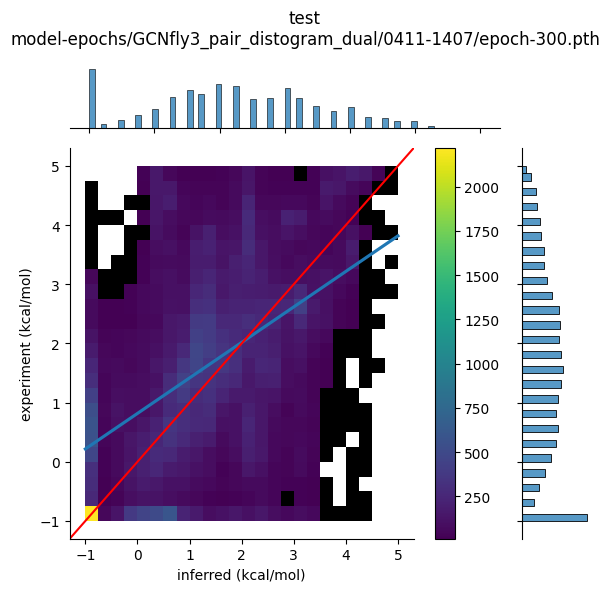

acc:	0.0999
mse:	2.2333
rmse:	1.4944
inacc:	0.3600
test_r2: 0.0931
test_mse: 2.2333
test_rmse: 1.4944
test_spearman: 0.4911
test_pearson: 0.4993


/home/annung202/miniconda3/envs/graph-dg/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


In [20]:
rescaling_factor = 24/6
y = labels / rescaling_factor - 1
# y = y_real
y_hat = preds / rescaling_factor - 1
bins = list(np.arange(-1, 5.25, .25))

acc = (y_hat == y)
acc = len(acc[acc]) / len(acc) # clever
mse = (torch.square((y_hat) - (y)).mean())
rmse = torch.sqrt(mse)

inacc = y_hat - y
inacc = len(inacc[torch.abs(inacc) <= .5])/len(y) # clever

cmap=plt.get_cmap("viridis")
cmap.set_under("black")

g = sns.jointplot(x=y_hat, y=y, kind="hist", cmap=cmap, zorder=0, bins=bins, cbar=1, vmin=10)
g.plot_joint(sns.regplot, scatter_kws=dict(alpha=0))
g.figure.suptitle(f"{split}\n{model_path}")
g.figure.tight_layout()
g.set_axis_labels('inferred (kcal/mol)', 'experiment (kcal/mol)')
g.ax_joint.axline((0, 0), slope=1, color='r')
plt.show()

print(f"acc:\t{acc:.4f}")
print(f"mse:\t{mse:.4f}")
print(f"rmse:\t{rmse:.4f}")
print(f"inacc:\t{inacc:.4f}")

metrics = get_metrics()
for metric in metrics.values():
    metric.update(y_hat, y)
metric_results = {name: metric.compute() for name, metric in metrics.items()}
for name, value in metric_results.items():
    print(f"{split}_{name}: {value.item():.4f}")

### Only high confidence predictions

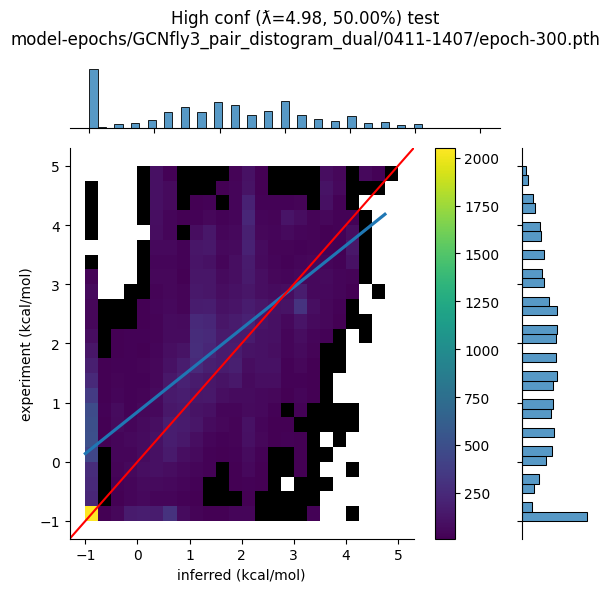

acc:	0.1276
mse:	2.0277
rmse:	1.4240
inacc:	0.3853
test_r2: 0.1931
test_mse: 2.0277
test_rmse: 1.4240
test_spearman: 0.6171
test_pearson: 0.6135


/home/annung202/miniconda3/envs/graph-dg/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


In [21]:
conf_cut = conf_mat.median() #q2
# conf_cut = conf_mat[conf_mat >= conf_mat.median()].median() #q1
rescaling_factor = 24/6
conf_bool = (conf_mat >= conf_cut)
yy = labels[conf_bool] / rescaling_factor - 1
# y = y_real
yy_hat = preds[conf_bool] / rescaling_factor - 1
bins = list(np.arange(-1, 5.25, .25))

percentage = 100*(len(yy)/len(labels))

acc = (yy_hat == yy)
acc = len(acc[acc]) / len(acc) # clever
mse = (torch.square((yy_hat) - (yy)).mean())
rmse = torch.sqrt(mse)

inacc = yy_hat - yy
inacc = len(inacc[torch.abs(inacc) <= .5])/len(yy) # clever

# g = sns.jointplot(x=x, y=y, kind="kde", color="blue", zorder=0, levels=6)
g = sns.jointplot(x=yy_hat, y=yy, kind="hist", cmap=cmap, zorder=0, bins=bins, cbar=1, vmin=10)
g.plot_joint(sns.regplot, scatter_kws=dict(alpha=0))
g.figure.suptitle(f"High conf (ƛ={conf_cut:.2f}, {percentage:.2f}%) {split}\n{model_path}")
g.figure.tight_layout()
g.set_axis_labels('inferred (kcal/mol)', 'experiment (kcal/mol)')
g.ax_joint.axline((0, 0), slope=1, color='r')
plt.show()

print(f"acc:\t{acc:.4f}")
print(f"mse:\t{mse:.4f}")
print(f"rmse:\t{rmse:.4f}")
print(f"inacc:\t{inacc:.4f}")

metrics = get_metrics()
for metric in metrics.values():
    metric.update(yy_hat, yy)
metric_results = {name: metric.compute() for name, metric in metrics.items()}
for name, value in metric_results.items():
    print(f"{split}_{name}: {value.item():.4f}")

### Low confidence predictions

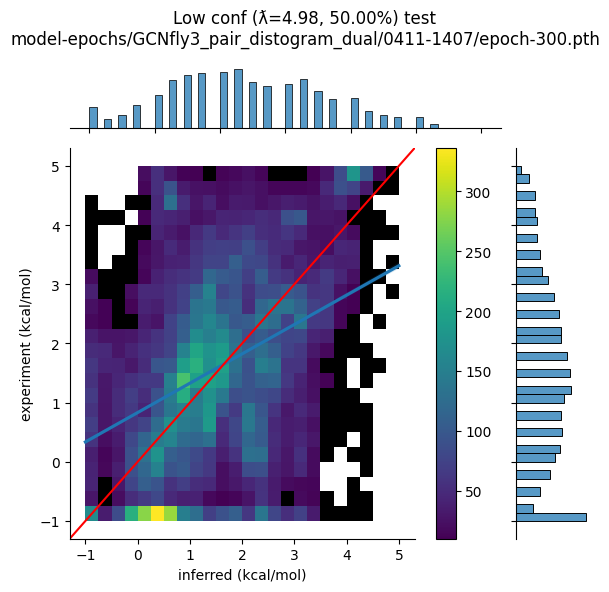

acc:	0.0721
mse:	2.4387
rmse:	1.5616
inacc:	0.3348
test_r2: -0.0114
test_mse: 2.4387
test_rmse: 1.5616
test_spearman: 0.3638
test_pearson: 0.3817


/home/annung202/miniconda3/envs/graph-dg/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


In [22]:
conf_bool = (conf_mat <= conf_cut)
yy = labels[conf_bool] / rescaling_factor - 1
# y = y_real
yy_hat = preds[conf_bool] / rescaling_factor - 1
bins = list(np.arange(-1, 5.25, .25))

percentage = 100*(len(yy)/len(labels))

acc = (yy_hat == yy)
acc = len(acc[acc]) / len(acc) # clever
mse = (torch.square((yy_hat) - (yy)).mean())
rmse = torch.sqrt(mse)

inacc = yy_hat - yy
inacc = len(inacc[torch.abs(inacc) <= .5])/len(yy) # clever

g = sns.jointplot(x=yy_hat, y=yy, kind="hist", cmap=cmap, zorder=0, bins=bins, cbar=1, vmin=10)
g.plot_joint(sns.regplot, scatter_kws=dict(alpha=0))
g.figure.suptitle(f"Low conf (ƛ={conf_cut:.2f}, {percentage:.2f}%) {split}\n{model_path}")
g.figure.tight_layout()
g.set_axis_labels('inferred (kcal/mol)', 'experiment (kcal/mol)')
g.ax_joint.axline((0, 0), slope=1, color='r')
plt.show()

print(f"acc:\t{acc:.4f}")
print(f"mse:\t{mse:.4f}")
print(f"rmse:\t{rmse:.4f}")
print(f"inacc:\t{inacc:.4f}")

metrics = get_metrics()
for metric in metrics.values():
    metric.update(yy_hat, yy)
metric_results = {name: metric.compute() for name, metric in metrics.items()}
for name, value in metric_results.items():
    print(f"{split}_{name}: {value.item():.4f}")

### An example plot

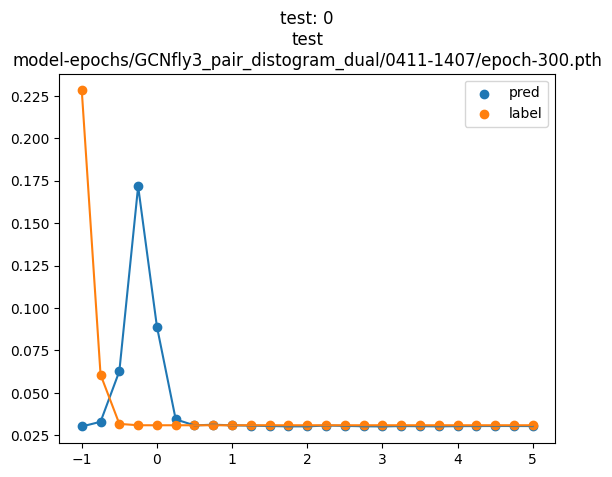

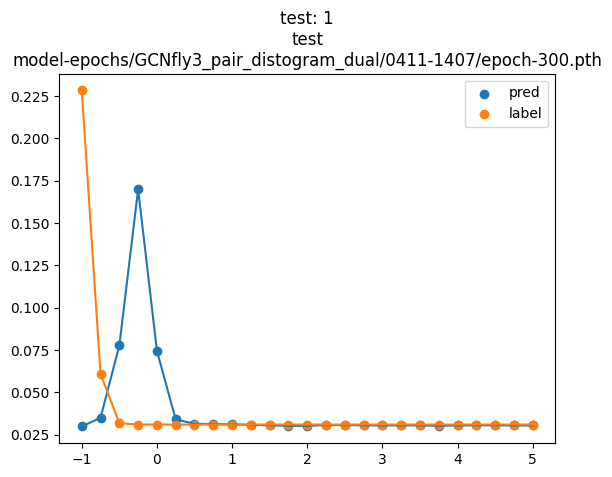

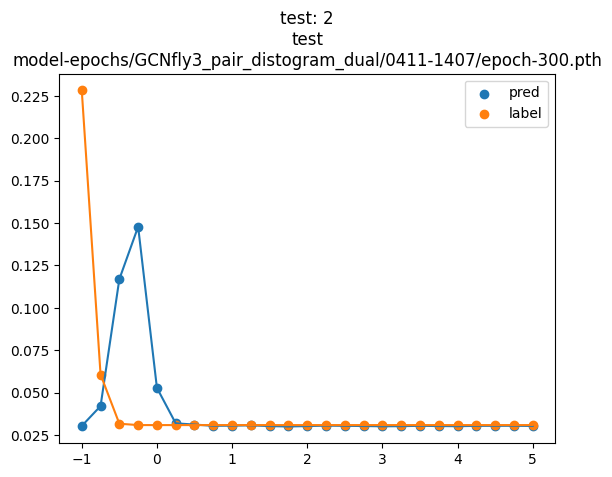

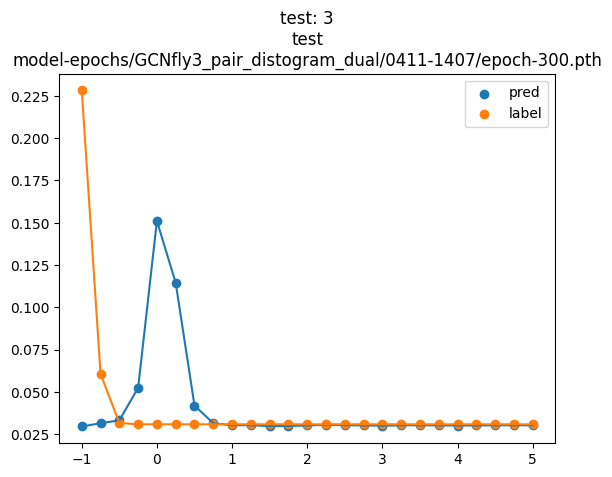

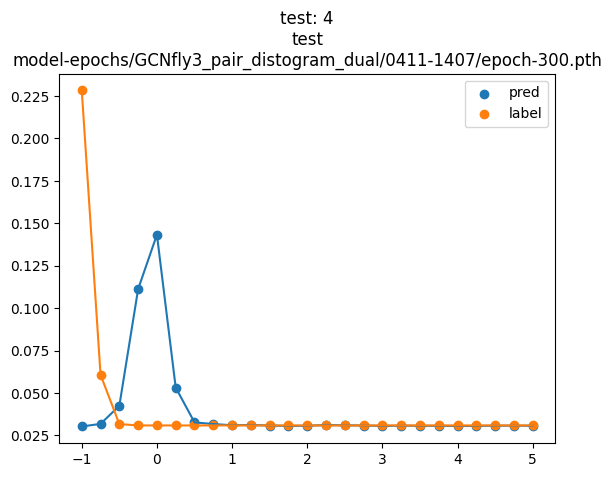

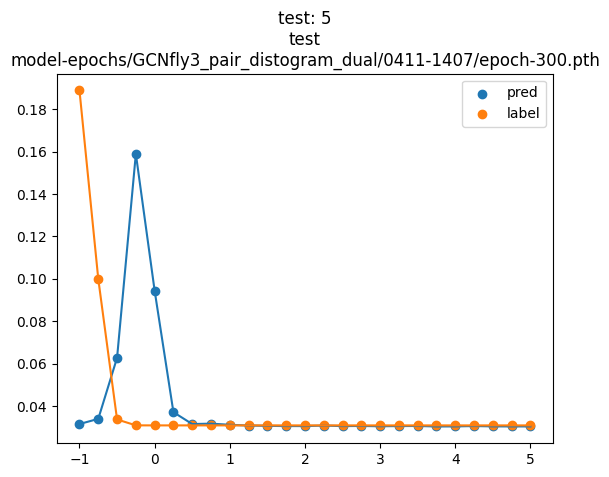

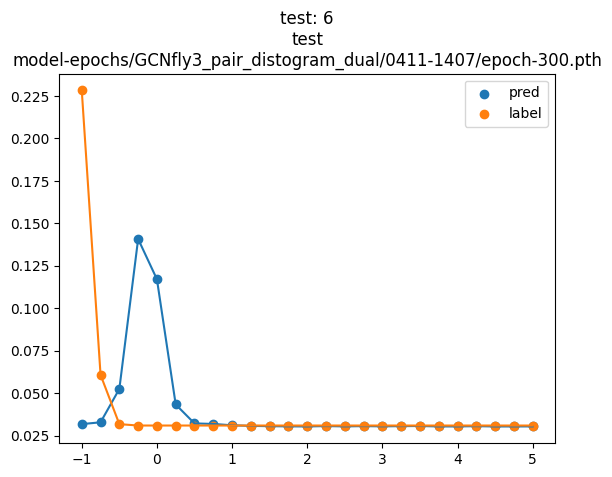

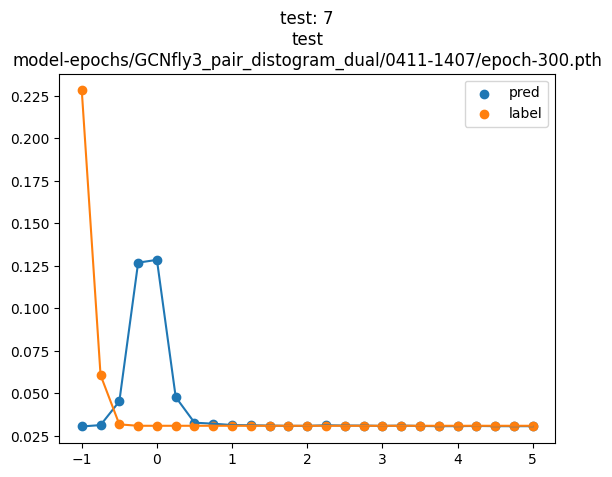

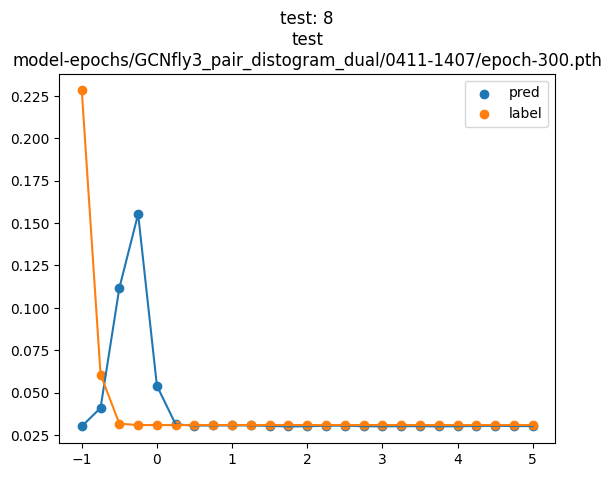

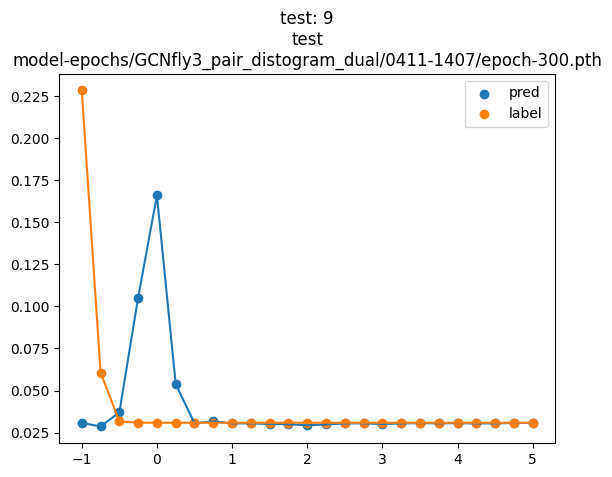

In [26]:
# b = 6
for b in range(0,10):
    # epoch = model_path.split('/')[-1].replace('.pth','')

    plt.title(f"{split}: {b}\n{split}\n{model_path}")
    plt.scatter(bins, pred[b,:].detach().cpu(), label=f"pred")
    plt.plot(bins, pred[b,:].detach().cpu())
    plt.scatter(bins, label[b,:].detach().cpu(), label=f"label")
    plt.plot(bins, label[b,:].detach().cpu())
    plt.legend()
    # plt.ylim(0,1)
    plt.show()

### Compare the data with other model

In [11]:
model2_path = "model-epochs/GATfly3_pair_distogram/0409-1114/epoch-4.pth"
model2 = Model().to(device)
model2.load_state_dict(torch.load(model2_path, map_location=device))
epoch2 = model2_path.split('/')[-1].replace('.pth','')
llabels, ppreds = torch.tensor([]), torch.tensor([])

conf_weight = False

with torch.no_grad():
    in_data = in_data.to(device)
    tp_data = tp_data.to(device)
    llabel = (torch.clamp(in_data.y,-1,5) + 1) / 6
    llabel = distogram(llabel)
    ppred = model2(in_data, tp_data)
    
    llabels = torch.concat((llabels,torch.argmax(llabel, dim=-1).detach().cpu()))
    ppreds = torch.concat((ppreds,torch.argmax(ppred, dim=-1).detach().cpu()))


plt.title(f"{split}: {b}\n{split}\n{model2_path}")
# for i, b in enumerate(range(39,41)):
plt.scatter(bins, ppred[b,:].detach().cpu(), label=f"pred")
plt.plot(bins, ppred[b,:].detach().cpu())
plt.scatter(bins, llabel[b,:].detach().cpu(), label=f"label")
plt.plot(bins, llabel[b,:].detach().cpu())
plt.legend()
# plt.ylim(0,1)
plt.show()

RuntimeError: Error(s) in loading state_dict for GCNfly3_pair_distogram_dual:
	Missing key(s) in state_dict: "gcn_input.conv1.bias", "gcn_input.conv1.lin.weight", "gcn_input.norm1.weight", "gcn_input.norm1.bias", "gcn_input.conv2.bias", "gcn_input.conv2.lin.weight", "gcn_input.norm2.weight", "gcn_input.norm2.bias", "gcn_input.conv3.bias", "gcn_input.conv3.lin.weight", "gcn_input.norm3.weight", "gcn_input.norm3.bias", "gcn_input.readout.weight", "gcn_input.readout.bias", "gcn_input.hidden.weight", "gcn_input.hidden.bias", "gcn_input.output.weight", "gcn_input.output.bias", "gcn_template.conv1.bias", "gcn_template.conv1.lin.weight", "gcn_template.norm1.weight", "gcn_template.norm1.bias", "gcn_template.conv2.bias", "gcn_template.conv2.lin.weight", "gcn_template.norm2.weight", "gcn_template.norm2.bias", "gcn_template.conv3.bias", "gcn_template.conv3.lin.weight", "gcn_template.norm3.weight", "gcn_template.norm3.bias", "gcn_template.readout.weight", "gcn_template.readout.bias", "gcn_template.hidden.weight", "gcn_template.hidden.bias", "gcn_template.output.weight", "gcn_template.output.bias". 
	Unexpected key(s) in state_dict: "gcn_double.conv1.bias", "gcn_double.conv1.lin.weight", "gcn_double.norm1.weight", "gcn_double.norm1.bias", "gcn_double.conv2.bias", "gcn_double.conv2.lin.weight", "gcn_double.norm2.weight", "gcn_double.norm2.bias", "gcn_double.conv3.bias", "gcn_double.conv3.lin.weight", "gcn_double.norm3.weight", "gcn_double.norm3.bias", "gcn_double.readout.weight", "gcn_double.readout.bias", "gcn_double.hidden.weight", "gcn_double.hidden.bias", "gcn_double.output.weight", "gcn_double.output.bias". 